## Exercise 3: Run on Tclab Device

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install tclab

In [3]:
pip install -U matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
from tclab import TCLab, clock, Historian, Plotter
import matplotlib.pyplot as plt

In [5]:
# parameter estimates.
alpha = 0.00016       # watts / (units P * percent U1)
P1 = 200              # P units
P2 = 100              # P units
CpH = 7.930            # heat capacity of the heater (J/deg C)
CpS = 1.399           # heat capacity of the sensor (J/deg C)
Ua = 0.043           # heat transfer coefficient from heater to environment
Ub = 0.1133            # heat transfer coefficient from heater to sensor
Uc = 0.0402           # heat transfer coefficient between heaters
Tamb = 21             # ambient room temperature

# state space model
A = np.array([[-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0], 
              [Ub/CpS, -Ub/CpS, 0, 0],
              [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH],
              [0, 0, Ub/CpS, -Ub/CpS]])

Bu = np.array([[alpha*P1/CpH, 0], [0, 0], [0, alpha*P2/CpH], [0, 0]])

Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])

C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])

# initial values for states and inputs
u_initial = np.array([0, 0])
d_initial = np.array([Tamb])
x_initial = np.array([Tamb, Tamb, Tamb, Tamb])

print(f'A = {A}')
print(f'Bu = {Bu}')
print(f'Bd = {Bd}')
print(f'C = {C}')

A = [[-0.02477932  0.01428752  0.00506936  0.        ]
 [ 0.08098642 -0.08098642  0.          0.        ]
 [ 0.00506936  0.         -0.02477932  0.01428752]
 [ 0.          0.          0.08098642 -0.08098642]]
Bu = [[0.00403531 0.        ]
 [0.         0.        ]
 [0.         0.00201765]
 [0.         0.        ]]
Bd = [[0.00542245]
 [0.        ]
 [0.00542245]
 [0.        ]]
C = [[0 1 0 0]
 [0 0 0 1]]


In [6]:
def tclab_observer(L, t_prev=0, x=[Tamb, Tamb, Tamb, Tamb], d=[Tamb]):
    while True:
        # yield current state estimate. Wait for message information
        # needed to update the state estimate for the next time step
        t, U1, U2, TS1, TS2, Tamb = yield x
        
        # Create arrays
        U = [U1, U2]
        y = [TS1, TS2]

        # prediction
        x = x + (t - t_prev)*(A@x + Bu@U + Bd@d)
        
        # correction
        x = x - (t - t_prev)*L@(C@x - y)
        t_prev = t

### Sensor Temperature Control

In [7]:
### Generator
def my_predictive_control(t_horizon=300, dt=2, alpha=0):
    # create time grid
    n = round(t_horizon/dt)
    t_grid = np.linspace(0, t_horizon, n+1)
    
    # create decision variables and all parts of the model
    # that do not depend on information from the event loop
    u = {t: cp.Variable(2, nonneg=True) for t in t_grid}
    x = {t: cp.Variable(4) for t in t_grid}
    y = {t: cp.Variable(2) for t in t_grid}
    output = [y[t] == C@x[t] for t in t_grid]
    inputs = [u[t] <= 100 for t in t_grid]

    MV1 = 0
    MV2 = 0

    while True:
        # yield MV, then wait for new information to update MV
        SP1, SP2, Th1, Ts1, Th2, Ts2, Tamb = yield MV1, MV2
        objective = cp.Minimize((1-alpha)*sum((y[t][0]-SP1)**2 for t in t_grid) + (1-alpha)*sum((y[t][1]-SP2)**2 for t in t_grid)
              + alpha*sum((u[t][0]-u[t-dt][0])**2 for t in t_grid[1:]) + alpha*sum((u[t][1]-u[t-dt][1])**2 for t in t_grid[1:]))
        model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[Tamb]) for t in t_grid[1:]]
        IC = [x[0] == np.array([Th1, Ts1, Th2, Ts2])]
        problem = cp.Problem(objective,  model + IC + output + inputs)
        problem.solve(warm_start=True)
        MV1 = u[0].value[0]
        MV2 = u[0].value[1]

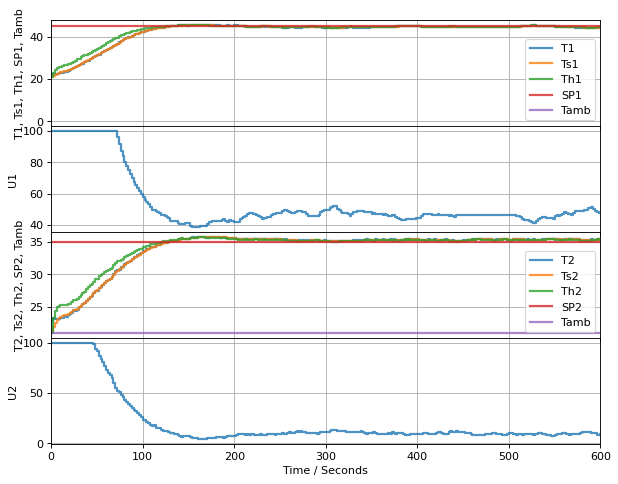

TCLab disconnected successfully.


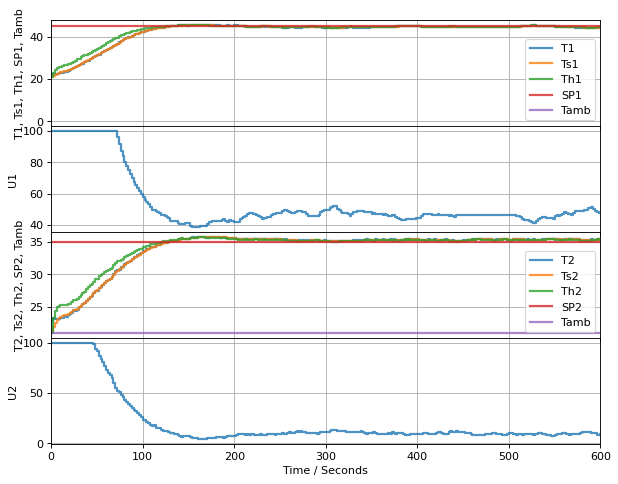

In [8]:
t_final = 600
t_step = 2

Tamb = 21
SP1 = 45
SP2 = 35

# create a controller instance
controller = my_predictive_control(dt=5, alpha=0.1)
U1, U2 = next(controller)

# create estimator instance
L = np.array([[0.4, 0], [0.2, 0], [0, 0.4], [0, 0.2]])
observer = tclab_observer(L)
Th1, Ts1, Th2, Ts2 = next(observer)

# execute the event loop
with TCLab() as lab:
    h = Historian([('SP1', lambda: SP1),
                   ('SP2', lambda: SP2),
                   ('T1', lambda: T1),
                   ('T2', lambda: T2), 
                   ('U1', lambda: U1),
                   ('U2', lambda: U2), 
                   ('Th1', lambda: Th1), 
                   ('Ts1', lambda: Ts1),
                   ('Th2', lambda: Th2),
                   ('Ts2', lambda: Ts2),
                   ('Tamb', lambda: Tamb)])
    p = Plotter(h, t_final, layout=[['T1','Ts1','Th1', 'SP1', 'Tamb'], ['U1'],['T2', 'Ts2', 'Th2', 'SP2', 'Tamb'], ['U2']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        T2 = lab.T2
        Th1, Ts1, Th2, Ts2 = observer.send([t, U1, U2, T1, T2, Tamb])
        U1, U2 = controller.send([SP1, SP2, Th1, Ts1, Th2, Ts2, Tamb])
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)

#### Discusion for Temperature Sensor Control

The setpoint was reached for both heater systems: Setpoint 1 was reached in 150 seconds and Setpoint 2 was reached in 300 seconds. The graphs for both heater settings demonstrate a smooth heater setting descent, demonstrating that the tunings from exercise 2 work well. There was more variability in the heater settings for Heater 1, but even Heater 1 maintained a smooth power requirement. 

### Heater Temperature Control

In [9]:
### Generator
def my_predictive_control(t_horizon=300, dt=2, alpha=0):
    # create time grid
    n = round(t_horizon/dt)
    t_grid = np.linspace(0, t_horizon, n+1)
    
    # create decision variables and all parts of the model
    # that do not depend on information from the event loop
    u = {t: cp.Variable(2, nonneg=True) for t in t_grid}
    x = {t: cp.Variable(4) for t in t_grid}
    y = {t: cp.Variable(2) for t in t_grid}
    output = [y[t] == C@x[t] for t in t_grid]
    inputs = [u[t] <= 100 for t in t_grid]

    MV1 = 0
    MV2 = 0

    while True:
        # yield MV, then wait for new information to update MV
        SP1, SP2, Th1, Ts1, Th2, Ts2, Tamb = yield MV1, MV2
        objective = cp.Minimize((1-alpha)*sum((x[t][0]-SP1)**2 for t in t_grid) + (1-alpha)*sum((x[t][2]-SP2)**2 for t in t_grid)
              + alpha*sum((u[t][0]-u[t-dt][0])**2 for t in t_grid[1:]) + alpha*sum((u[t][1]-u[t-dt][1])**2 for t in t_grid[1:]))
        model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[Tamb]) for t in t_grid[1:]]
        IC = [x[0] == np.array([Th1, Ts1, Th2, Ts2])]
        problem = cp.Problem(objective,  model + IC + output + inputs)
        problem.solve(warm_start=True)
        MV1 = u[0].value[0]
        MV2 = u[0].value[1]

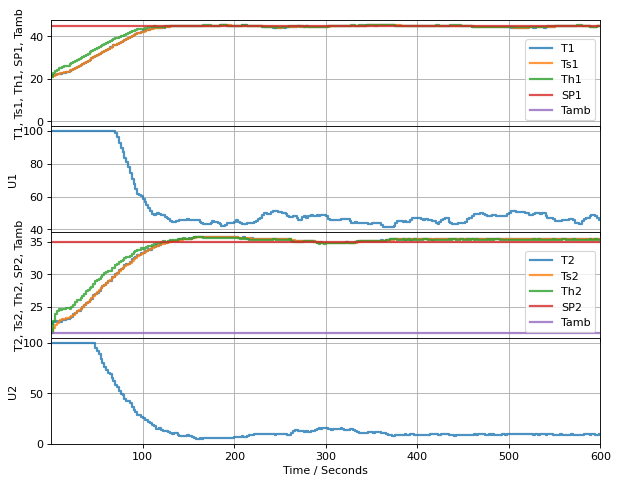

TCLab disconnected successfully.


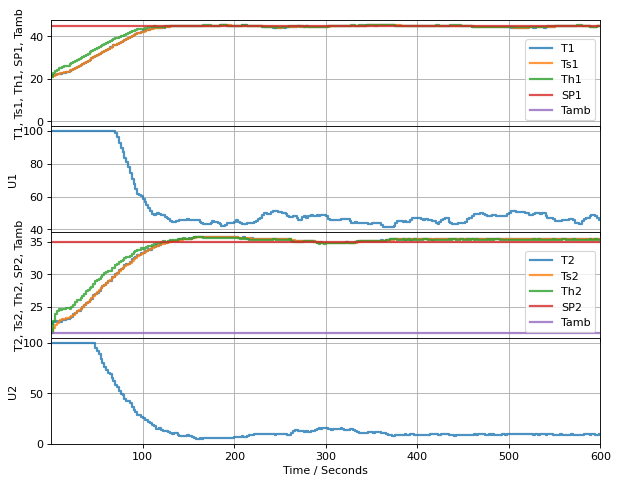

In [11]:
t_final = 600
t_step = 2

Tamb = 21
SP1 = 45
SP2 = 35

# create a controller instance
controller = my_predictive_control(dt=5, alpha=0.1)
U1, U2 = next(controller)

# create estimator instance
L = np.array([[0.4, 0], [0.2, 0], [0, 0.4], [0, 0.2]])
observer = tclab_observer(L)
Th1, Ts1, Th2, Ts2 = next(observer)

# execute the event loop
with TCLab() as lab:
    h = Historian([('SP1', lambda: SP1),
                   ('SP2', lambda: SP2),
                   ('T1', lambda: T1),
                   ('T2', lambda: T2), 
                   ('U1', lambda: U1),
                   ('U2', lambda: U2), 
                   ('Th1', lambda: Th1), 
                   ('Ts1', lambda: Ts1),
                   ('Th2', lambda: Th2),
                   ('Ts2', lambda: Ts2),
                   ('Tamb', lambda: Tamb)])
    p = Plotter(h, t_final, layout=[['T1','Ts1','Th1', 'SP1', 'Tamb'], ['U1'],['T2', 'Ts2', 'Th2', 'SP2', 'Tamb'], ['U2']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        T2 = lab.T2
        Th1, Ts1, Th2, Ts2 = observer.send([t, U1, U2, T1, T2, Tamb])
        U1, U2 = controller.send([SP1, SP2, Th1, Ts1, Th2, Ts2, Tamb])
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)

#### Discussion for Heater Temperature Control

The predictive control system for the heater system worked well: the setpoint for Heater 1 was achieved in 150 seconds, and Heater 2 reached a temperature nearing the setpoint after around 250 seconds. In addition, both heater settings were adjusted smoothly, demonstrating that the tunings from Exercise 2 worked well. However, an interesting development occured with the second setpoint: the heater temperature was consistently about 1 degree Celsius above the setpoint. This may be a physical constraint issue with the TCLab in which the two setpoints cannot be easily achieved at the same time with both heaters working. Otherwise, this error may be due to the equation that cvxpy is optimizing: there is a balance between minimizing error for heater 1 and minimizing error for heater 2, meaning that heater 2 may be slightly inaccurate. However, even with the 1 degree error, the predictive control system tracks both setpoints well. 